# CoinGame solver using multi-agent policy gradient (MAPG) with a shared classical policy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

2024-02-01 13:57:06.404729: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
import numpy as np


def generate_model_policy_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [5]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [6]:
# Shared actor.
model_policy = generate_model_policy_classical(
    n_actions=n_actions,
    units=[256, 128],
    name=f"policy-classical-shared"
    )
optimizer_policy = keras.optimizers.Adam(learning_rate=1e-3)

model_policy.build((None, observation_dim))
model_policy.summary()

Model: "policy-classical-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 256)               9472      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 policy (Dense)              (None, 4)                 516       
                                                                 
Total params: 42,884
Trainable params: 42,884
Non-trainable params: 0
_________________________________________________________________


## Training

In [7]:
gamma = 0.99
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAPG(
    env=env,
    model_policy=model_policy,
    optimizer_policy=optimizer_policy,
    gamma=gamma,
    episode_metrics_callback=episode_metrics_callback,
    )

reward_history, metrics_history = algo.train(n_episodes=3000)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 1024:  34%|███▍      | 1024/3000 [07:44<14:55,  2.21episode/s, coins_collected=111, discounted_reward=1.15, episode_reward=[ 5. -4.], own_coin_rate=0.505, own_coins_collected=56, undiscounted_reward=1]    

Terminating early at episode 1024


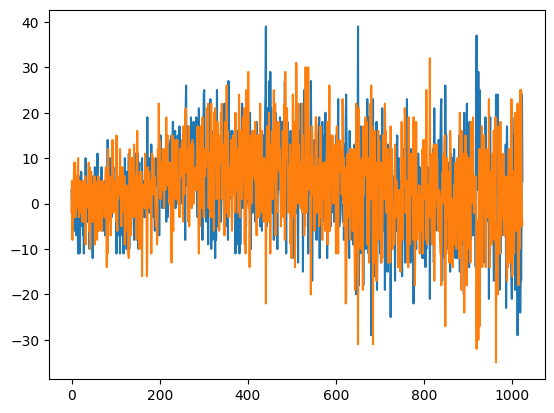

In [8]:
plt.plot(reward_history)

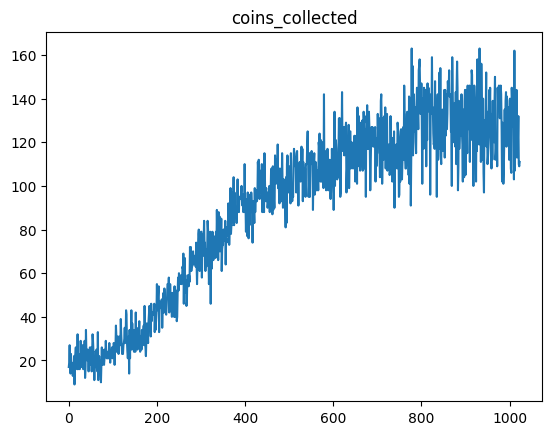

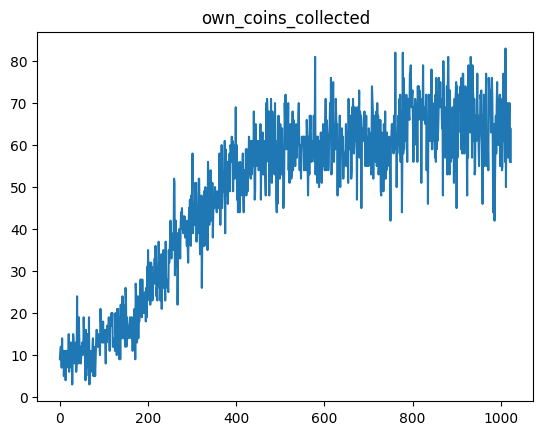

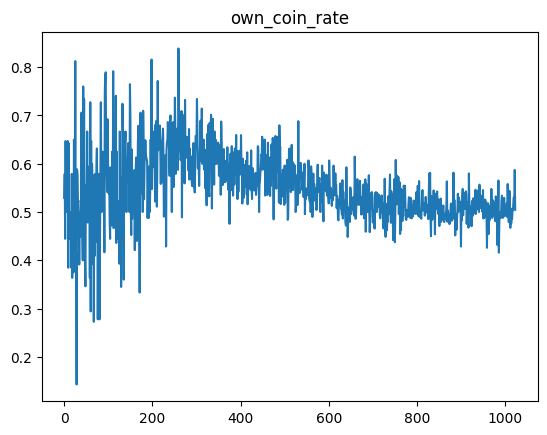

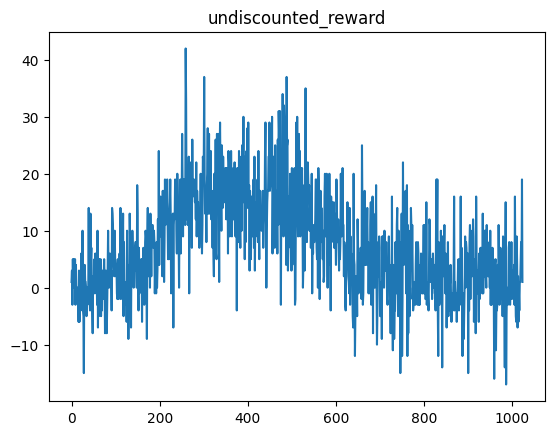

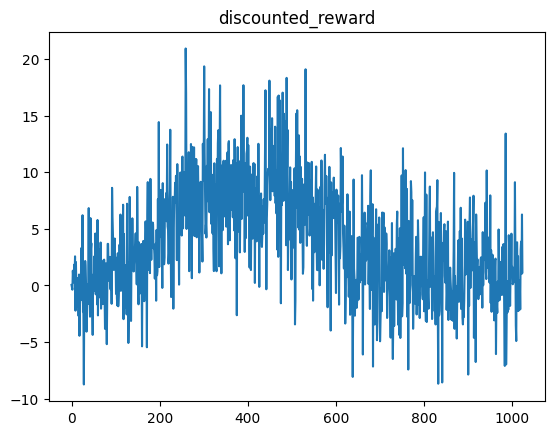

In [9]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)